# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep='delimiter', delimiter = ';')
azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep='delimiter', delimiter = ';')

##### Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info[feat_info.attribute == 'GREEN_AVANTGARDE']

,attribute,information_level,type,missing_or_unknown
13,GREEN_AVANTGARDE,person,categorical,[]


In [8]:
azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

###### Identify missing or unknown data values and convert them to NaNs.

In [9]:
azdias = azdias_df.copy()

In [10]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
feat_info_azdias = feat_info.copy()

In [12]:
feat_info_azdias[feat_info_azdias.type == 'ordinal']

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
14,HEALTH_TYP,person,ordinal,"[-1,0]"
23,RETOURTYP_BK_S,person,ordinal,[0]
24,SEMIO_SOZ,person,ordinal,"[-1,9]"


In [13]:
feat_info_azdias.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [14]:
feat_info_azdias.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [15]:
type(feat_info_azdias.iloc[1]['missing_or_unknown'])

str

In [16]:
len(feat_info_azdias)

85

In [17]:
feat_info_azdias.shape

(85, 4)

In [18]:
# convert missing values to nan
def convert_missing_to_nan(df1, df2):
    for i in range(len(df2)):
        missing_unknown = df2.iloc[i]['missing_or_unknown'].strip('[').strip(']').split(',')
        if missing_unknown != ['']:
            missing_unknown = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            miss = {df2.iloc[i]['attribute']: missing_unknown}
            df1 = df1.replace(miss, np.nan)
        else:
            pass
            
    return df1

azdias = convert_missing_to_nan(azdias, feat_info_azdias)

In [19]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_cols = azdias.isnull().sum().sort_values(ascending = False)

missing_cols

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

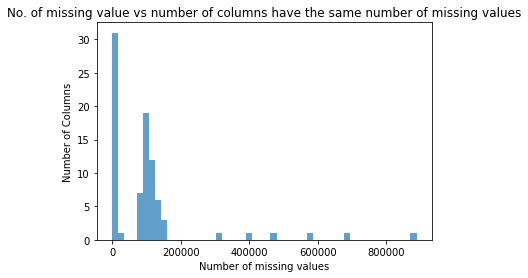

In [22]:
plt.hist(missing_cols, 50, histtype="stepfilled", alpha=.7)
plt.xlabel('Number of missing values')
plt.ylabel('Number of Columns')
plt.title("No. of missing value vs number of columns have the same number of missing values")
plt.show();

In [23]:
percent = azdias.isnull().sum() / azdias.shape[0]
percent.sort_values(ascending = False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

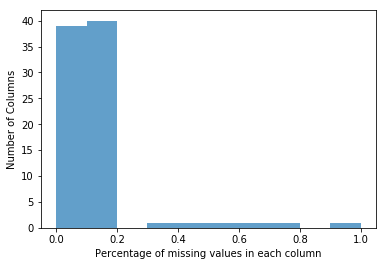

In [24]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(percent, 10, histtype="stepfilled", alpha=.7)
plt.xlabel('Percentage of missing values in each column')
plt.ylabel('Number of Columns')
plt.show()

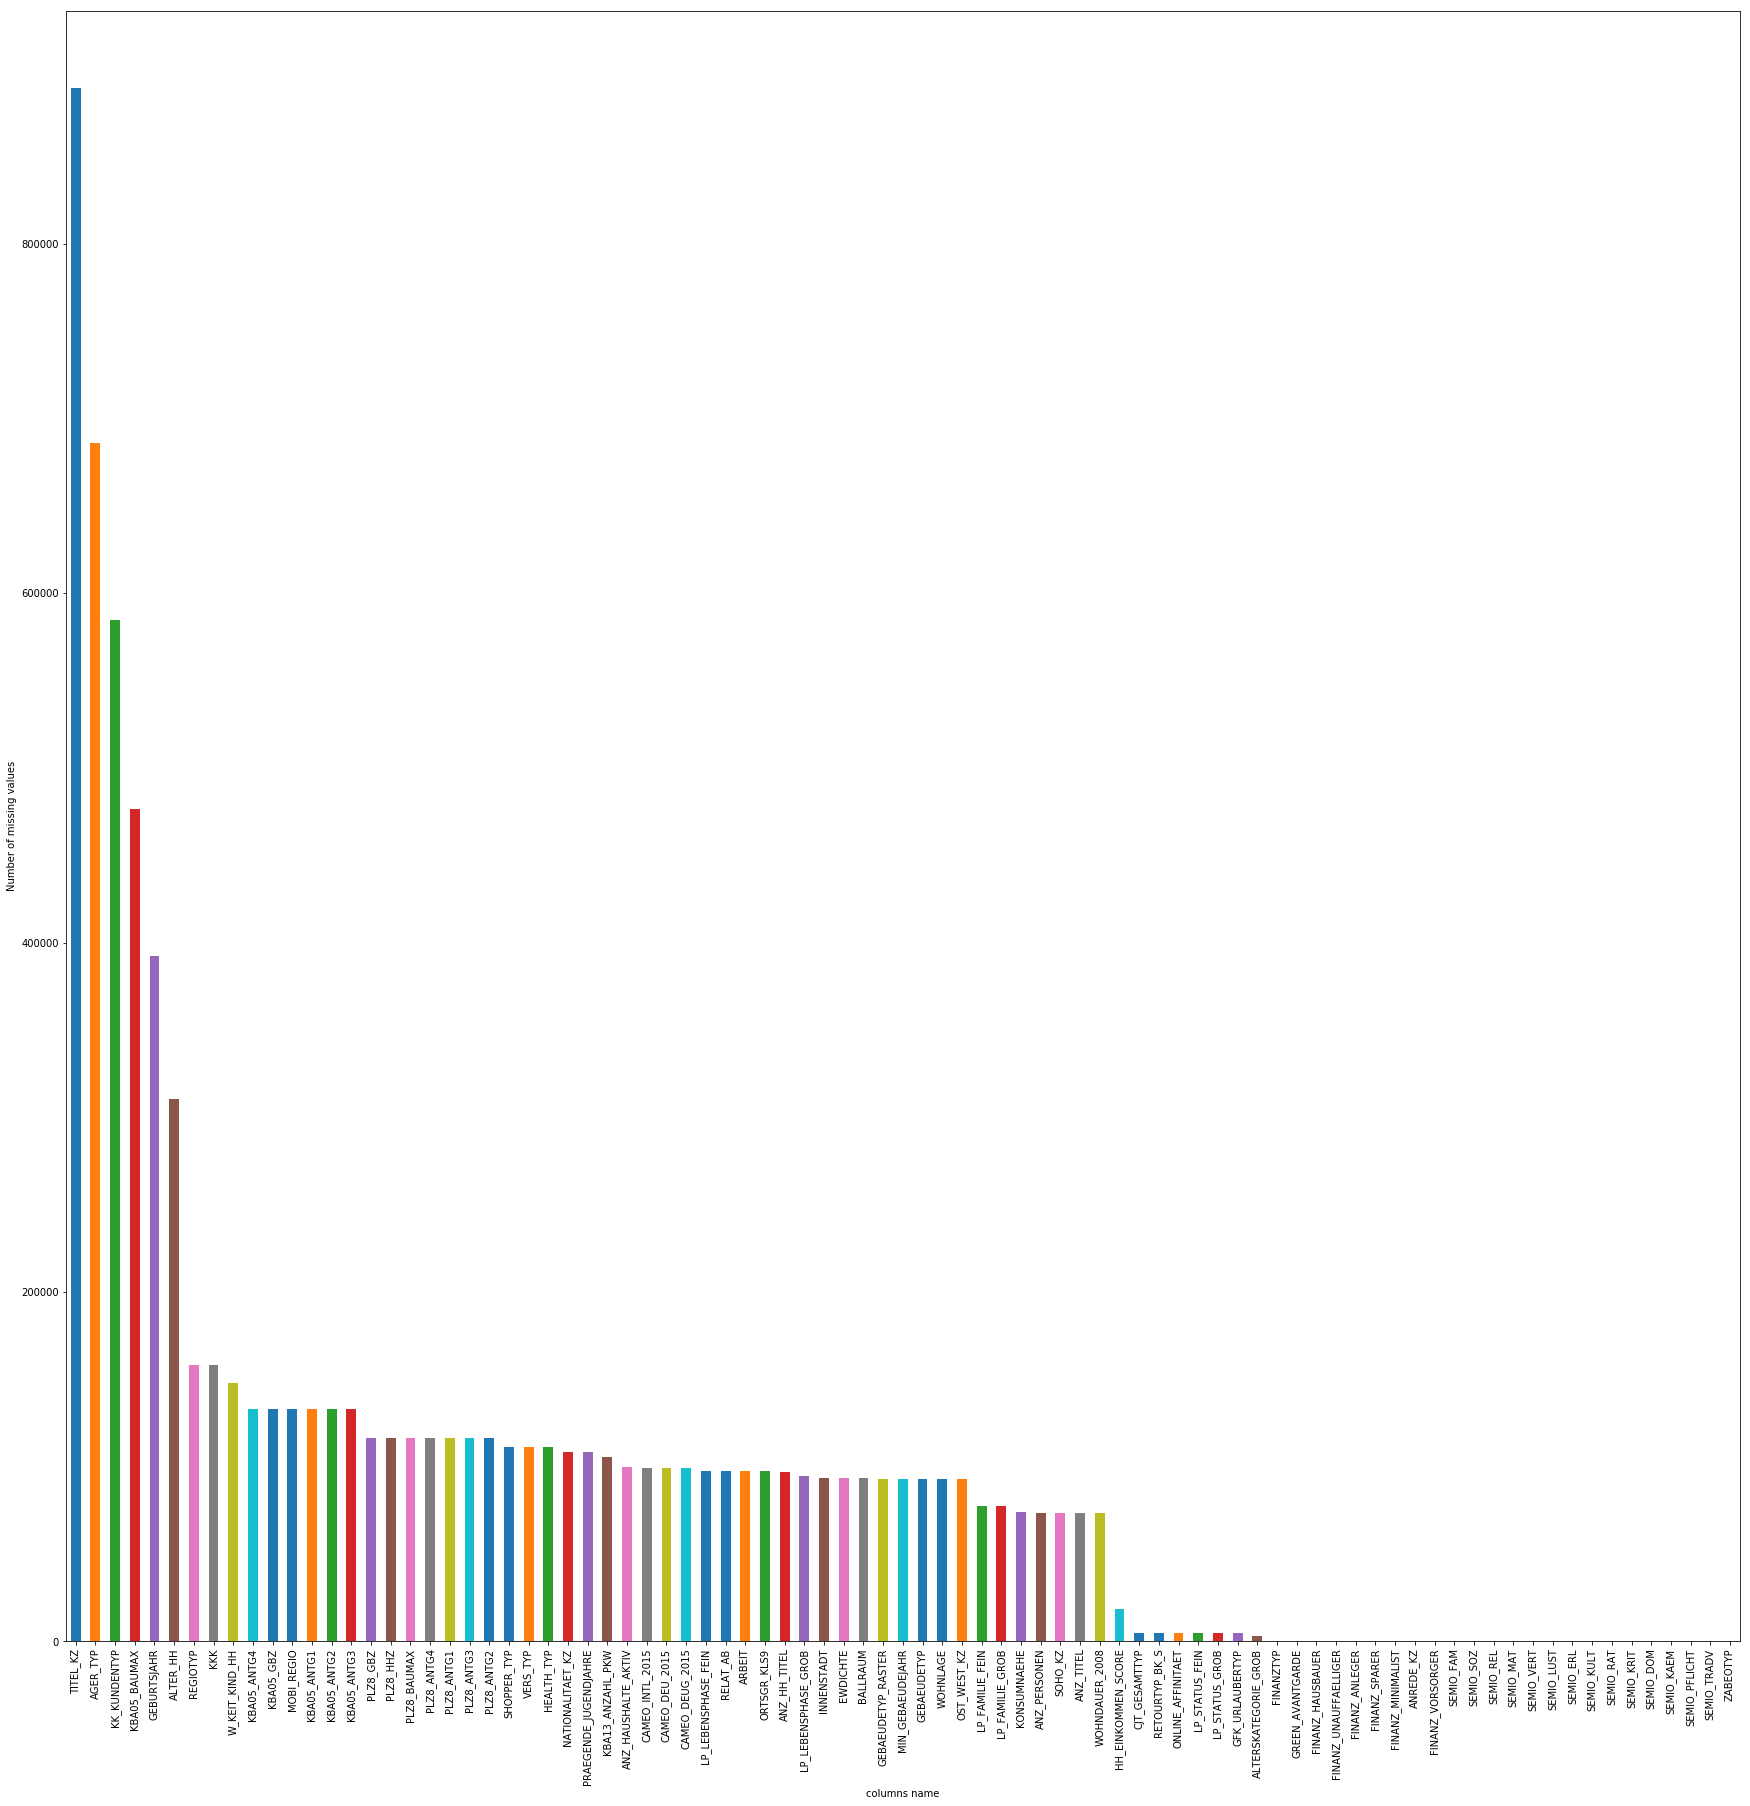

In [25]:
missing_cols.plot.bar(figsize = (30, 30))
plt.xlabel('columns name')
plt.ylabel('Number of missing values')
plt.show()

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop = list(percent[percent > .3].index) # to get the name of columns that has over 30% missing values
drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [27]:
azdias.drop(drop, axis = 1, inplace = True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

This data has a lot of columns containing missing values, most  of the columns have missing values less than 15% from the original data, so i decided to consider any column has more than 1% missing values as an outlier and drop it.
These are the columns that were dropped.

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis=1)
missing_rows.sort_values()

445610     0
540274     0
540275     0
540277     0
540280     0
540281     0
540283     0
540284     0
540286     0
540273     0
540287     0
540290     0
540291     0
540292     0
540293     0
540295     0
540296     0
540298     0
540299     0
540289     0
540300     0
540271     0
540269     0
540239     0
540240     0
540241     0
540242     0
540243     0
540244     0
540246     0
          ..
139521    47
690887    47
690878    47
690876    47
690871    47
139478    47
139236    47
691118    47
691129    47
691317    47
139243    47
139245    47
139248    47
139250    47
139255    47
139267    47
691122    47
691212    47
139323    47
691197    47
139332    47
691183    47
691171    47
691142    47
691141    47
139316    47
183108    47
472919    48
732775    49
643174    49
Length: 891221, dtype: int64

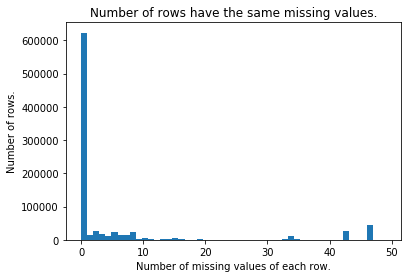

In [29]:
plt.hist(missing_rows, 50)
plt.xlabel('Number of missing values of each row.')
plt.ylabel('Number of rows.')
plt.title('Number of rows have the same missing values.')
plt.show()

In [30]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# I make threshold by having more than 3 missing values.


def split(df, threshold):
    gt_threshold = azdias[df >= threshold]
    st_threshold = azdias[df < threshold]
    return gt_threshold, st_threshold

azdias_gt, azdias_st = split(missing_rows, 10) # we will work further on azdias_st

In [31]:
azdias_gt.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
azdias_st.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [33]:
# select_columns to compare

com_cols = azdias_st.isnull().sum().sort_values(ascending = False)[:6].index
com_cols

Index(['W_KEIT_KIND_HH', 'KKK', 'REGIOTYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'HEALTH_TYP'],
      dtype='object')

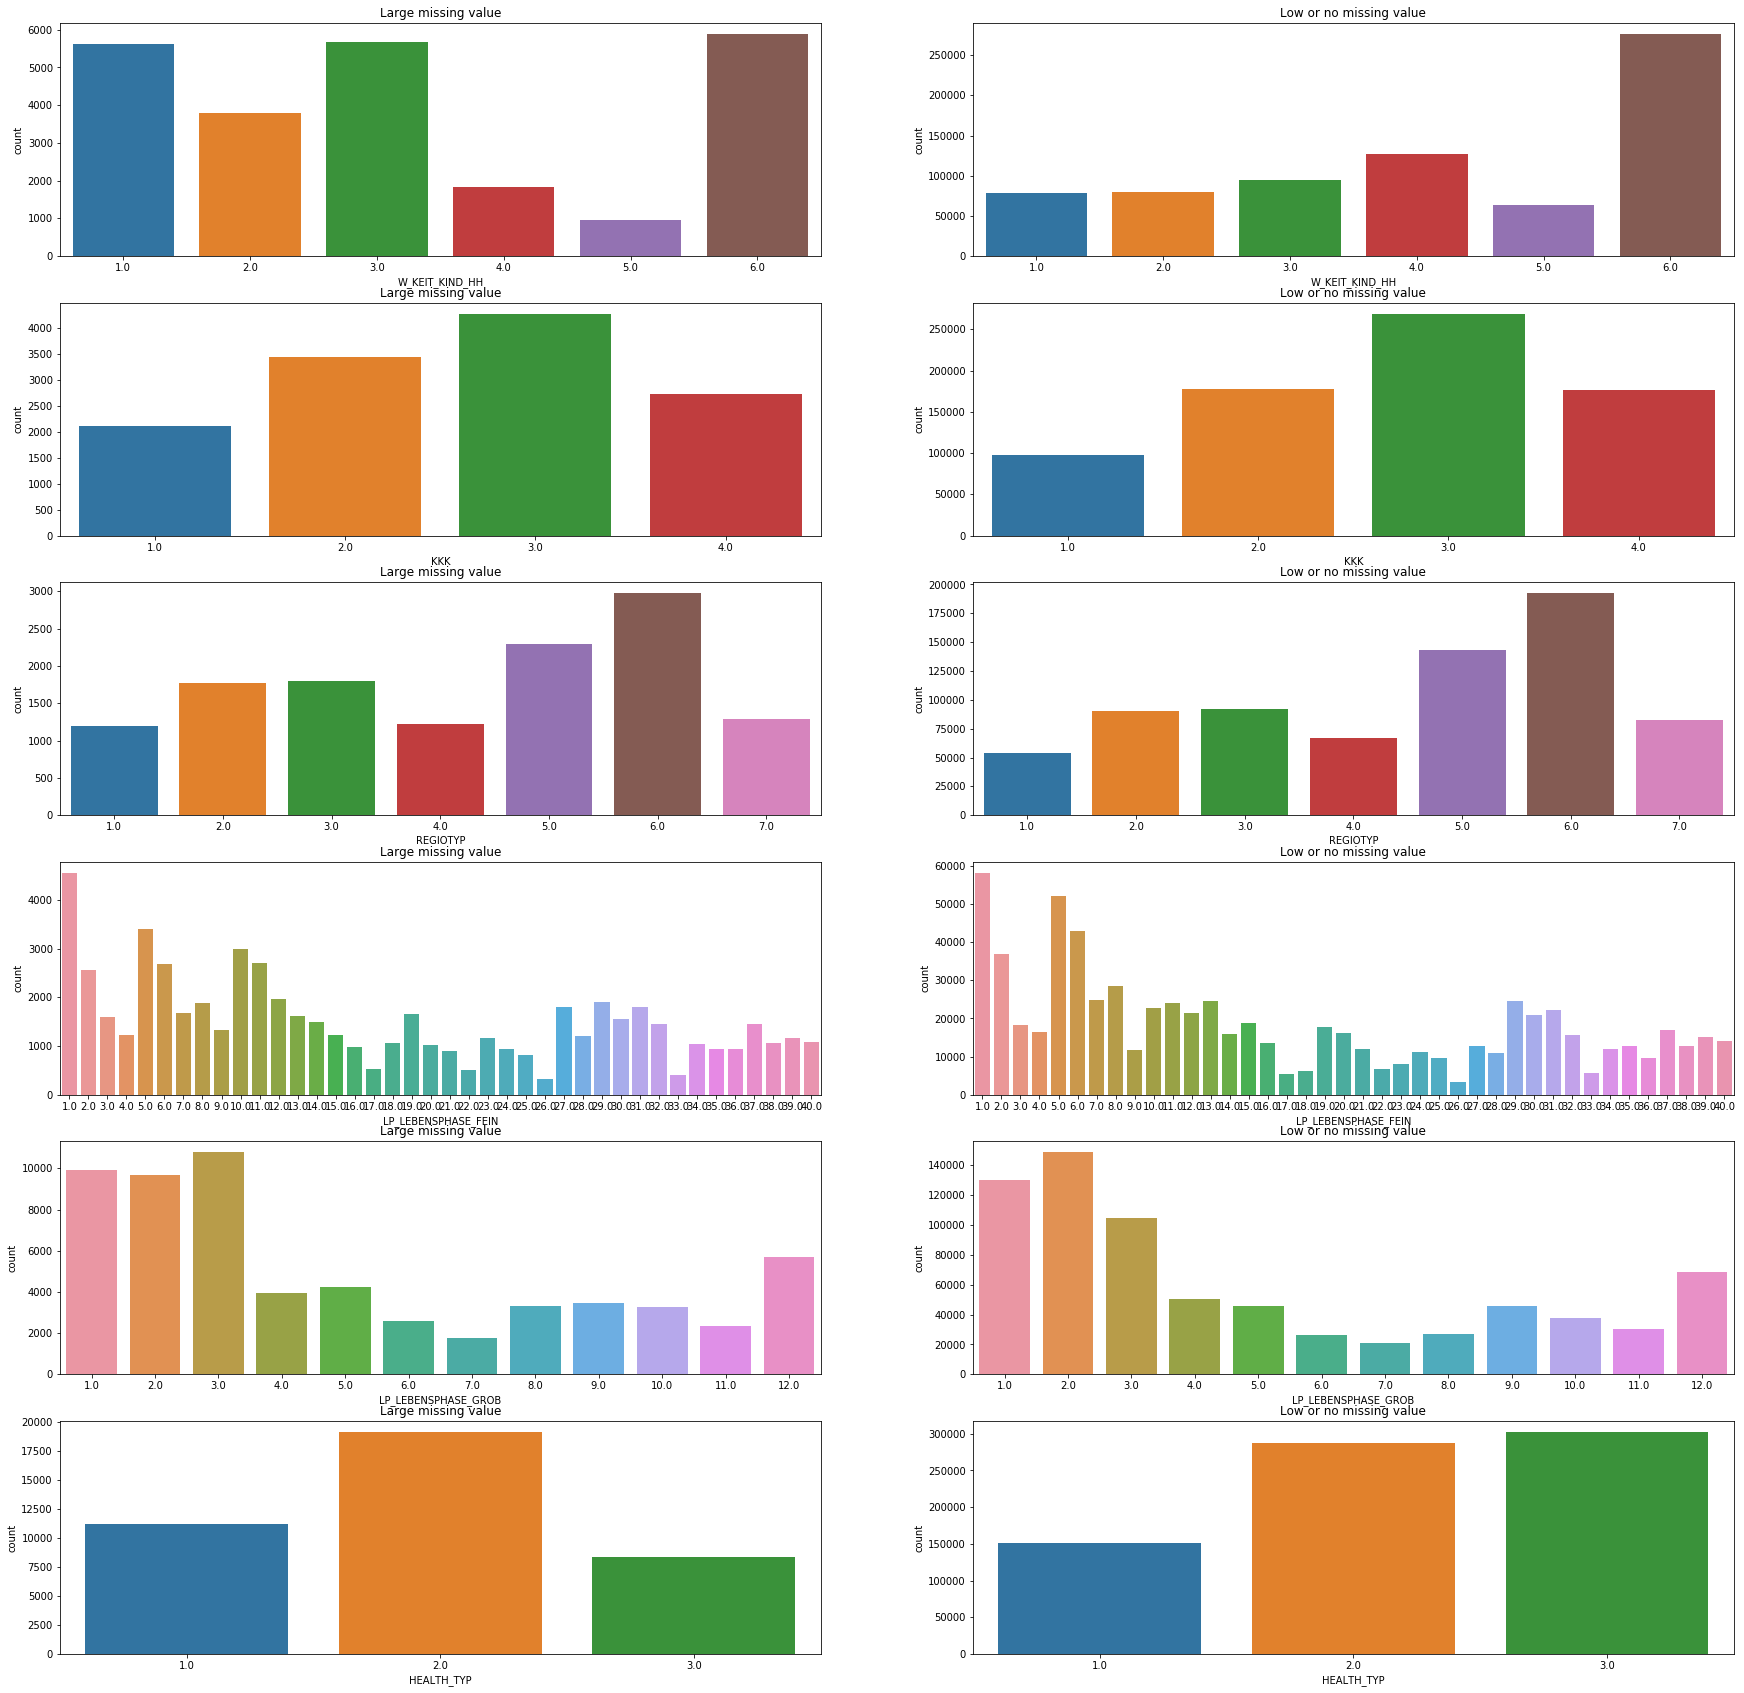

In [34]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot(cols):
    
    fig, ax = plt.subplots(nrows = 6, ncols = 2, figsize = (30, 30))
    for i in range(len(com_cols)):
        sns.countplot(azdias_gt[com_cols[i]], ax=ax[i][0]).set_title('Large missing value')
        sns.countplot(azdias_st[com_cols[i]], ax=ax[i][1]).set_title('Low or no missing value')
plot(com_cols)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
<p>
Many of the features have the same distribution and the difference is not significant

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [36]:
drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [37]:
for col in drop:
    feat_info_azdias = feat_info_azdias[feat_info_azdias.attribute != col]
    
feat_info_azdias.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [38]:
# How many features are there of each data type?

feat_info_azdias.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_cat = feat_info_azdias[feat_info_azdias.type == 'categorical']
feat_info_cat = list(feat_info_cat.attribute.values)
feat_info_cat

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [40]:
azdias_st.VERS_TYP.nunique()

2

In [41]:
len(azdias_st.GREEN_AVANTGARDE.unique())

2

In [42]:
def cat(df, cat_cols):
    binary = []
    multi = []
    
    for col in feat_info_cat:
        if df[col].nunique() == 2:
            binary.append(col)
        elif df[col].nunique() > 2:
            multi.append(col)
    return binary, multi
binary, multi = cat(azdias_st, feat_info_cat)       

In [43]:
binary, multi

(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'],
 ['CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015'])

In [44]:
# Check binary
for col in binary:
    value1 = azdias_st[col].unique()
    value2 = azdias_st[col].nunique()
    print("the {} column has {} unique values".format(col, value2))
    print("The {} column has the following value {}".format(col, value1))

the ANREDE_KZ column has 2 unique values
The ANREDE_KZ column has the following value [2 1]
the GREEN_AVANTGARDE column has 2 unique values
The GREEN_AVANTGARDE column has the following value [0 1]
the SOHO_KZ column has 2 unique values
The SOHO_KZ column has the following value [ 1.  0.]
the VERS_TYP column has 2 unique values
The VERS_TYP column has the following value [  2.   1.  nan]
the OST_WEST_KZ column has 2 unique values
The OST_WEST_KZ column has the following value ['W' 'O']


In [45]:
# Check multi
for col in multi:
    value = azdias_st[col].unique()
    print("The {} column has the following value {}".format(col, value))

The CJT_GESAMTTYP column has the following value [ 5.  3.  2.  4.  1.  6.]
The FINANZTYP column has the following value [1 6 5 2 4 3]
The GFK_URLAUBERTYP column has the following value [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
The LP_FAMILIE_FEIN column has the following value [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
The LP_FAMILIE_GROB column has the following value [  3.   1.  nan   5.   2.   4.]
The LP_STATUS_FEIN column has the following value [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.]
The LP_STATUS_GROB column has the following value [ 1.  2.  4.  5.  3.]
The NATIONALITAET_KZ column has the following value [  1.   3.   2.  nan]
The SHOPPER_TYP column has the following value [  3.   2.   1.   0.  nan]
The ZABEOTYP column has the following value [5 3 4 1 6 2]
The GEBAEUDETYP column has the following value [ 8.  1.  3.  2.  6.  4.  5.]
The CAMEO_DEUG_2015 column has the following value ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
The CAM

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.

# 1) Reencode the azdias_st['OST_WEST_KZ'] column to be numeric
azdias_st['OST_WEST_KZ'] = azdias_st['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1)
azdias_st['OST_WEST_KZ'].unique()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


array([0, 1])

# 2) Reencode the CAMEO_DEU_2015 column to be numeric

def split(word): 
    return [char for char in word]  

azdias_st['CAMEO_DEU_2015'] = azdias_st['CAMEO_DEU_2015'].apply(lambda x: int(split(x)[0]))
azdias_st['CAMEO_DEU_2015'].unique()

# 3) Reencode the CAMEO_DEUG_2015 column to be numeric
azdias_st['CAMEO_DEUG_2015'] = azdias_st['CAMEO_DEUG_2015'].apply(lambda x: int(x))
azdias_st['CAMEO_DEUG_2015'].unique()

In [47]:
for col in multi:
    azdias_st = azdias_st.drop(col, axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<p> 1) Reencode the azdias_st['OST_WEST_KZ'] column to be numeric
<p> 2) Reencode the CAMEO_DEU_2015 column to be numeric
<p> 3) Reencode the CAMEO_DEUG_2015 column to be numeric

Actually after doing some cleaning on some of the multi categorical columns i decided to drop the multi categorical features


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_st.PRAEGENDE_JUGENDJAHRE.unique()

azdias_st['decade'] = azdias_st.PRAEGENDE_JUGENDJAHRE
azdias_st['movement'] = azdias_st.PRAEGENDE_JUGENDJAHRE

In [49]:
def reform(x):
    # 40s 
    if x in (1,2):
        return 1
    # 50s
    elif x in (3 ,4):
        return 2 
    # 60s
    elif x in (5, 6, 7):
        return 3 
    # 70s
    elif x in (8, 9):
        return 4 
    # 80s
    elif x in (10, 11, 12, 13):
        return 5 
    # 90s
    else:
        return 6

azdias_st['decade'] =  azdias_st['decade'].apply(reform) 

In [50]:
azdias_st['decade'].unique()

array([6, 4, 2, 5, 3, 1])

In [51]:
def reform2(x):
    # Mainstream movemnet
    if x in (1, 3 , 5, 8, 10, 12, 14):
        return 0 
    # Avantgarde Movement
    else:
        return 1

azdias_st['movement'] =  azdias_st['movement'].apply(reform2)

In [52]:
azdias_st['movement'].unique()

array([0, 1])

In [53]:
azdias_st.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [54]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


azdias_st.CAMEO_INTL_2015.unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [55]:
azdias_st.CAMEO_INTL_2015.head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [56]:
azdias_st.isnull().sum(axis=1)

1         0
2         0
3         5
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        6
13        8
15        8
16        4
18        3
19        0
21        0
22        0
23        8
25        3
27        0
28        0
29        2
31        0
32        0
33        0
34        2
36        0
37        0
38        0
         ..
891190    0
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    0
891208    3
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    3
891217    2
891218    3
891219    0
891220    0
Length: 774743, dtype: int64

In [57]:
azdias_st['CAMEO_INTL_2015'] = pd.to_numeric(azdias_st['CAMEO_INTL_2015'])

In [58]:
azdias_st['Wealth'] = azdias_st.CAMEO_INTL_2015
azdias_st['Life Stage'] = azdias_st.CAMEO_INTL_2015

In [59]:
def Wealth(x):
    # Wealthy Households 
    if x in (11,12, 13, 14, 15):
        return 1
    # Prosperous Households
    elif x in (21, 22, 23 ,24, 25):
        return 2 
    # Comfortable Households
    elif x in (31, 32, 33, 34, 35):
        return 3 
    # Less Affluent Households
    elif x in (41, 42, 43, 44, 45):
        return 4  
    # Poorer Households
    else:
        return 5

azdias_st['Wealth'] =  azdias_st['Wealth'].apply(Wealth) 

In [60]:
azdias_st['Wealth'].unique()

array([5, 2, 1, 4, 3])

In [61]:
def Life_Stage(x):
    # Pre-Family Couples & Singles
    if x in (11,21, 31, 41, 51):
        return 1
    # Young Couples With Children
    elif x in (12, 22, 32, 42 ,52):
        return 2 
    # Families With School Age Children
    elif x in (13, 23, 33, 43, 53):
        return 3 
    # Older Families & Mature Couples
    elif x in (14, 24, 34, 44, 54):
        return 4  
    # Elders In Retirement
    else:
        return 5
    
azdias_st['Life Stage'] =  azdias_st['Life Stage'].apply(Life_Stage)

In [62]:
azdias_st['Life Stage'].unique()

array([1, 4, 2, 3, 5])

In [63]:
azdias_st.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [64]:
# Check other mixed value column
feat_info_azdias[feat_info_azdias.type == 'mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [65]:
# other mixed features
mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [66]:
azdias_st.drop(mixed, axis = 1, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<p> 1) I created two new variables to each feature and applied function to each new variable
<p> 2) I extracted the new information from data_dictionary.md file as said in the instruction
<p> 3) I tried to automate the process as possible but also it need a lot of manual work
<p> 4) I removed the original columns
<p> 5) i removed all other mixed columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1

# Already Done in previous step

In [68]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


# Already Done in previous step

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
# Predefined Functions

# 1) 

# convert missing values to nan
def convert_missing_to_nan(df1, df2):
    for i in range(len(df2)):
        missing_unknown = df2.iloc[i]['missing_or_unknown'].strip('[').strip(']').split(',')
        if missing_unknown != ['']:
            missing_unknown = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            miss = {df2.iloc[i]['attribute']: missing_unknown}
            df1 = df1.replace(miss,np.nan)
        else:
            pass
            
    return df1


# 2) 
def split(df2, df, threshold):
    gt_threshold = df[df2 >= threshold]
    st_threshold = df[df2 < threshold]
    return gt_threshold, st_threshold 

# 3) 
def cat(df3, cat_cols):
    binary = []
    multi = []
    for col in feat_info_cat:
        if df3[col].nunique() == 2:
            binary.append(col)
        elif df3[col].nunique() > 2:
            multi.append(col)
    return binary, multi


# 4) 
def reform(x):
    # 40s
    if x in (1,2):
        return 1
    # 50s
    elif x in (3 ,4):
        return 2 
    # 60s
    elif x in (5, 6, 7):
        return 3 
    # 70s
    elif x in (8, 9):
        return 4 
    # 80s
    elif x in (10, 11, 12, 13):
        return 5 
    # 90s
    else:
        return 6

# 5) 
def reform2(x):
    # Mainstream movemnet
    if x in (1, 3 , 5, 8, 10, 12, 14):
        return 0 
    # Avantgarde Movement
    else:
        return 1
    
# 6) 
def Wealth(x):
    # Wealthy Households 
    if x in (11,12, 13, 14, 15):
        return 1
    # Prosperous Households
    elif x in (21, 22, 23 ,24, 25):
        return 2 
    # Comfortable Households
    elif x in (31, 32, 33, 34, 35):
        return 3 
    # Less Affluent Households
    elif x in (41, 42, 43, 44, 45):
        return 4  
    # Poorer Households
    else:
        return 5
    
# 7) 
def Life_Stage(x):
    # Pre-Family Couples & Singles
    if x in (11,21, 31, 41, 51):
        return 1
    # Young Couples With Children
    elif x in (12, 22, 32, 42 ,52):
        return 2 
    # Families With School Age Children
    elif x in (13, 23, 33, 43, 53):
        return 3 
    # Older Families & Mature Couples
    elif x in (14, 24, 34, 44, 54):
        return 4  
    # Elders In Retirement
    else:
        return 5

In [70]:
def clean_data(df, threshold):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    
    args:
    df: input dataframe
    threshold: maximum accepted number of missing value in each row
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # convert missing values to nan
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep='delimiter', delimiter = ';')
    df = convert_missing_to_nan(df, feat_info)
     
    # remove selected columns and rows, ...
    
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    
    percent = df.isnull().sum() / df.shape[0]


    drop = list(percent[percent > .33].index) # to get the name of columns that has over 15% missing values

    df.drop(drop, axis = 1, inplace = True)
    # Write code to divide the data into two subsets based on the number of missing values in each row.

    # I make threshold by having more than 3 missing values.
    # How much data is missing in each row of the dataset?
    missing_rows = df.isnull().sum(axis=1)
    missing_rows.sort_values()

    df_gt, df_st = split(missing_rows, df, threshold)
    
    ################################### we will work further on df_st
    for col in drop:
        feat_info = feat_info[feat_info.attribute != col]
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    feat_info_cat = feat_info[feat_info.type == 'categorical']
    feat_info_cat = list(feat_info_cat.attribute.values)
    
    binary, multi = cat(df_st, feat_info_cat)
    
    
    for col in multi:
        df_st = df_st.drop(col, axis = 1)
        
    # 1) Reencode the azdias_st['OST_WEST_KZ'] column to be numeric
    df_st['OST_WEST_KZ'] = df_st['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1)
    
    # select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis.  
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    df_st['decade'] = df_st.PRAEGENDE_JUGENDJAHRE
    df_st['movement'] = df_st.PRAEGENDE_JUGENDJAHRE
    

    df_st['decade'] =  df_st['decade'].apply(reform) 
    

    df_st['movement'] =  df_st['movement'].apply(reform2)
    
    df_st.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    
    df_st['CAMEO_INTL_2015'] = pd.to_numeric(df_st['CAMEO_INTL_2015'])

    df_st['Wealth'] = df_st.CAMEO_INTL_2015
    df_st['Life Stage'] = df_st.CAMEO_INTL_2015


    df_st['Wealth'] =  df_st['Wealth'].apply(Wealth) 

    
    df_st['Life Stage'] =  df_st['Life Stage'].apply(Life_Stage)


    df_st.drop('CAMEO_INTL_2015', axis = 1, inplace = True)


    # other mixed features
    mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

    df_st.drop(mixed, axis = 1, inplace = True)

    
    # Return the cleaned dataframe.
    
    return df_st

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [94]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

cols = azdias_st.columns

imputer = Imputer(strategy='mean', axis=0, verbose=0)
azdias_st_imputed = imputer.fit_transform(azdias_st)
azdias_st_imputed

array([[ 1.,  2.,  1., ...,  0.,  5.,  1.],
       [ 3.,  2.,  1., ...,  1.,  2.,  4.],
       [ 4.,  2.,  4., ...,  0.,  1.,  2.],
       ..., 
       [ 2.,  2.,  2., ...,  0.,  2.,  4.],
       [ 1.,  1.,  1., ...,  0.,  5.,  1.],
       [ 4.,  1.,  4., ...,  0.,  4.,  3.]])

In [72]:
azdias_st_imputed = pd.DataFrame(azdias_st_imputed, columns = cols)
azdias_st_imputed.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
                        ..
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
K

In [73]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_st_scaled = scaler.fit_transform(azdias_st_imputed)

In [74]:
azdias_st_scaled = pd.DataFrame(azdias_st_scaled, columns = cols)

In [75]:
azdias_st_scaled.shape

(774743, 64)

In [76]:
azdias_st_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life Stage
0,-1.765007,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.077799,...,0.414545,1.432085,0.560706,-0.175332,-0.133626,0.679067,1.106006,-0.581892,1.170872,-1.260547
1,0.199492,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.077799,...,-0.967205,0.399744,0.560706,-0.175332,-0.133626,-0.796120,1.106006,1.718533,-0.874330,0.750923
2,1.181742,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,...,-0.967205,-0.632597,0.560706,-1.180995,-1.004475,-0.058527,-0.259273,-0.581892,-1.556065,-0.590057
3,0.199492,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.077799,...,0.414545,-0.632597,-0.343393,0.830331,0.301799,1.416660,-0.259273,-0.581892,0.489138,0.080433
4,-1.765007,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.077799,...,0.414545,1.432085,1.464805,-1.180995,-1.004475,-0.058527,-1.624552,-0.581892,1.170872,0.750923


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
<p>I imputed the missing values using the mean of all other values in the same column and also i applied standard scaler which is sclae all feature to be on same scale toprevent any feature that has a lrage range to affect the algorithm

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [77]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_st_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

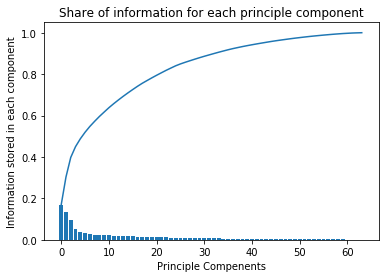

In [78]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Principle Compenents')
plt.ylabel('Information stored in each component')
plt.title('Share of information for each principle component')
plt.show();

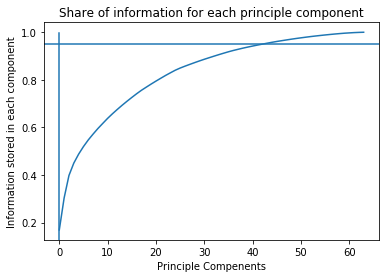

In [79]:
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.axvline(ymax = 0.95)
plt.axhline(y=0.95, xmin=0, xmax=1)
plt.xlabel('Principle Compenents')
plt.ylabel('Information stored in each component')
plt.title('Share of information for each principle component')
plt.show();


In [80]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_45 = PCA(n_components = 45)
pca45 = pca_45.fit_transform(azdias_st_scaled)
pca45


array([[ 3.89516896, -2.59852634, -2.89209234, ..., -0.31748146,
        -0.02590328, -0.05381374],
       [-0.90277893,  0.25558124, -3.12065703, ...,  0.17264674,
         0.69528069,  0.27133878],
       [-3.94982615,  1.25335034, -0.75033357, ..., -0.29609885,
         0.32461456,  0.46699345],
       ..., 
       [-0.91209063, -3.33518463, -2.94537408, ...,  0.30375314,
         0.42352558, -0.34290376],
       [ 5.88494649, -3.30825677,  2.32969341, ..., -1.01458025,
        -0.39675497,  0.10756676],
       [-0.73857983,  1.04607962,  3.11558155, ..., -0.65414456,
        -0.74867473, -0.3611148 ]])

In [81]:
pca_45.components_

array([[-0.11816096,  0.00713746, -0.2187368 , ..., -0.09188035,
         0.20641059, -0.12518346],
       [ 0.25999026,  0.09014674,  0.06841075, ..., -0.00657264,
         0.07237675,  0.00219407],
       [ 0.07911145, -0.36935275,  0.15674113, ...,  0.0343926 ,
         0.02703624, -0.00866132],
       ..., 
       [-0.02484695, -0.01173335, -0.07435978, ...,  0.06324782,
        -0.26628319, -0.05407387],
       [ 0.04534646, -0.04502617, -0.05416151, ...,  0.00154601,
        -0.10450646, -0.0370998 ],
       [ 0.04702268,  0.00877025,  0.05468463, ...,  0.02508147,
        -0.04568842, -0.05168565]])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I plot the pca compoents to know where are the 95 % of the information are stored, and i found that thery are stored in the first 45 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def Pca_weights(pca, col):
    Pca = pd.DataFrame(pca.components_, columns = cols)
    weights = Pca.iloc[col].sort_values(ascending = False)
    return weights
Pca_weights(pca_45, 0)

PLZ8_ANTG3               0.227292
PLZ8_ANTG4               0.220375
Wealth                   0.206411
HH_EINKOMMEN_SCORE       0.203618
ORTSGR_KLS9              0.198481
EWDICHTE                 0.196693
FINANZ_HAUSBAUER         0.162567
PLZ8_ANTG2               0.154745
KBA05_ANTG4              0.153100
FINANZ_SPARER            0.144933
ARBEIT                   0.144305
RELAT_AB                 0.136060
ANZ_HAUSHALTE_AKTIV      0.135832
KBA05_ANTG3              0.135388
SEMIO_PFLICHT            0.113477
SEMIO_REL                0.110886
decade                   0.103844
SEMIO_RAT                0.093257
SEMIO_TRADV              0.087268
SEMIO_MAT                0.078175
SEMIO_FAM                0.077249
FINANZ_UNAUFFAELLIGER    0.073529
REGIOTYP                 0.072554
SEMIO_KULT               0.071491
FINANZ_ANLEGER           0.067290
OST_WEST_KZ              0.053747
KKK                      0.043429
SEMIO_SOZ                0.042685
PLZ8_HHZ                 0.041921
SEMIO_KAEM    

In [83]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
Pca_weights(pca_45, 1)


ALTERSKATEGORIE_GROB     0.259990
FINANZ_VORSORGER         0.232870
SEMIO_ERL                0.230819
SEMIO_LUST               0.182136
RETOURTYP_BK_S           0.163917
W_KEIT_KIND_HH           0.118276
SEMIO_KRIT               0.116796
FINANZ_HAUSBAUER         0.114676
SEMIO_KAEM               0.112134
PLZ8_ANTG3               0.092605
EWDICHTE                 0.091266
ANREDE_KZ                0.090147
ORTSGR_KLS9              0.089868
PLZ8_ANTG4               0.088395
Wealth                   0.072377
SEMIO_DOM                0.070125
FINANZ_MINIMALIST        0.068411
KBA05_ANTG4              0.067879
ARBEIT                   0.066613
RELAT_AB                 0.064191
PLZ8_ANTG2               0.063813
ANZ_HAUSHALTE_AKTIV      0.061517
WOHNDAUER_2008           0.059392
HH_EINKOMMEN_SCORE       0.053069
KBA05_ANTG3              0.042311
VERS_TYP                 0.033135
ANZ_HH_TITEL             0.030759
OST_WEST_KZ              0.025298
REGIOTYP                 0.021245
PLZ8_HHZ      

In [84]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Pca_weights(pca_45, 2)


SEMIO_VERT               0.346616
SEMIO_SOZ                0.263336
SEMIO_FAM                0.250125
SEMIO_KULT               0.234295
FINANZ_MINIMALIST        0.156741
RETOURTYP_BK_S           0.109212
FINANZ_VORSORGER         0.100769
W_KEIT_KIND_HH           0.090789
ALTERSKATEGORIE_GROB     0.079111
SEMIO_REL                0.069918
SEMIO_LUST               0.064090
SEMIO_MAT                0.054503
GREEN_AVANTGARDE         0.045730
ORTSGR_KLS9              0.045130
PLZ8_ANTG4               0.044722
EWDICHTE                 0.044614
PLZ8_ANTG3               0.044236
movement                 0.034393
ARBEIT                   0.033828
WOHNDAUER_2008           0.032701
RELAT_AB                 0.030723
PLZ8_ANTG2               0.029415
Wealth                   0.027036
KBA05_ANTG4              0.026775
ANZ_HAUSHALTE_AKTIV      0.025064
OST_WEST_KZ              0.015267
VERS_TYP                 0.014811
ANZ_HH_TITEL             0.012959
ANZ_TITEL                0.009476
KBA05_ANTG3   

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [85]:
# Over a number of different cluster counts...
def kmeans(df, n_clusters):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans = kmeans.fit(df)
    # compute the average within-cluster distances.
    score = kmeans.score(df)
    score = np.abs(score)
    return score

In [86]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
n_clusters = list(np.arange(10, 20, 2))
for n_cluster in n_clusters:
    score = kmeans(pca45, n_cluster)
    scores.append(np.abs(score))

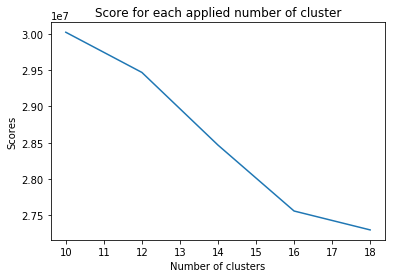

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

plt.plot(n_clusters, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.title('Score for each applied number of cluster')
plt.show();

In [88]:
kmeans16 = KMeans(n_clusters = 16)
model_16 = kmeans16.fit(pca45)
azdias_pred = model_16.predict(pca45)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Idecided to use 16 clusters for this dataset as it is more significant that the data shows some different in the projection.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [89]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

dt_st = clean_data(customers, 10)
dt_st.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,Wealth,Life Stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2,1,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2,1,3,4
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1,0,2,4
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4,0,4,1
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2,1,3,4


In [95]:
#customer_st_imputed = imputer.fit_transform(dt_st)

customer_st_imputed = imputer.transform(dt_st)
customer_st_imputed

array([[ 4.,  1.,  5., ...,  1.,  1.,  3.],
       [ 4.,  2.,  5., ...,  1.,  3.,  4.],
       [ 4.,  1.,  5., ...,  0.,  2.,  4.],
       ..., 
       [ 4.,  1.,  5., ...,  1.,  2.,  4.],
       [ 3.,  2.,  2., ...,  0.,  2.,  4.],
       [ 2.,  1.,  5., ...,  0.,  3.,  3.]])

In [96]:
customer_st_imputed = pd.DataFrame(customer_st_imputed, columns = dt_st.columns)

In [97]:
# Apply feature scaling to the general population demographics data.

customer_st_scaled = scaler.transform(customer_st_imputed)

In [98]:
customer_st_scaled = pd.DataFrame(customer_st_scaled, columns = dt_st.columns)

In [99]:
customers_pca = pca_45.transform(customer_st_scaled)

In [100]:
customers_pred = model_16.predict(customers_pca)
customers_pred

array([15,  4, 11, ..., 15, 12, 11], dtype=int32)

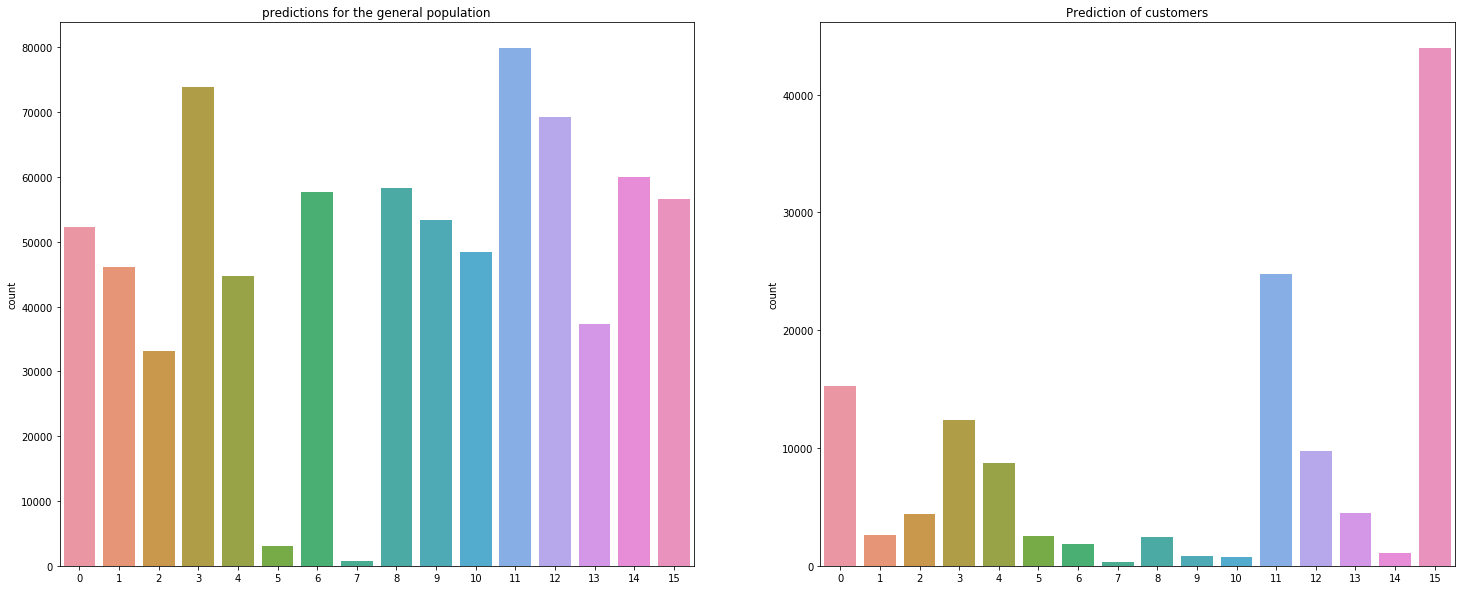

In [103]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def plot():
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))
    sns.countplot(azdias_pred, ax=ax[0]).set_title('predictions for the general population')
    sns.countplot(customers_pred, ax=ax[1]).set_title('Prediction of customers')
plot()

In [104]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Cluster_15 = scaler.inverse_transform(pca_45.inverse_transform(model_16.cluster_centers_[15]))

In [106]:
features1 = pd.DataFrame(Cluster_15, index = dt_st.columns)
features1.columns = ['Cluster_15']
features1.head()

,Cluster_15
ALTERSKATEGORIE_GROB,3.315771
ANREDE_KZ,1.037220
FINANZ_MINIMALIST,4.815228
FINANZ_SPARER,1.626065
FINANZ_VORSORGER,4.239212


In [107]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Cluster_14 = scaler.inverse_transform(pca_45.inverse_transform(model_16.cluster_centers_[14]))

In [108]:
features2 = pd.DataFrame(Cluster_14, index = dt_st.columns)
features2.columns = ['Cluster_14']
features2.head()

,Cluster_14
ALTERSKATEGORIE_GROB,1.810247
ANREDE_KZ,0.972456
FINANZ_MINIMALIST,1.896381
FINANZ_SPARER,4.387567
FINANZ_VORSORGER,2.055463


In [109]:
features = pd.merge(features1,features2, left_index=True, right_index=True)
features.head(10)

,Cluster_15,Cluster_14
ALTERSKATEGORIE_GROB,3.315771,1.810247
ANREDE_KZ,1.037220,0.972456
FINANZ_MINIMALIST,4.815228,1.896381
FINANZ_SPARER,1.626065,4.387567
FINANZ_VORSORGER,4.239212,2.055463
FINANZ_ANLEGER,1.547793,3.566237
FINANZ_UNAUFFAELLIGER,2.166676,3.788517
FINANZ_HAUSBAUER,1.923508,3.613971
GREEN_AVANTGARDE,0.966440,0.116090
HEALTH_TYP,2.062404,2.346609


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

In [116]:
features2

,Cluster_14
ALTERSKATEGORIE_GROB,1.810247
ANREDE_KZ,0.972456
FINANZ_MINIMALIST,1.896381
FINANZ_SPARER,4.387567
FINANZ_VORSORGER,2.055463
FINANZ_ANLEGER,3.566237
FINANZ_UNAUFFAELLIGER,3.788517
FINANZ_HAUSBAUER,3.613971
GREEN_AVANTGARDE,0.116090
HEALTH_TYP,2.346609


###### Discussion About the previous visualization:

<p> 1) The cluster number 9 in the customer data is overrepresented in the customer data compared to the general population data by which the mail company should focus on these customers and these some of theri characteristics
<ol>
    <li>Customers between 46 - 60 years old</li>
    <li>Male</li>
    <li>lives in Prosperous Households </li>
    <li>Belongs to Avantgarde Movement</li>
    <li>Mostly Older Families & Mature Couple</li>
</ol>

Thses customers are saving money.

<p> 2) The cluster number 12 in the customer data is underrepresented in the customer data compared to the general population data so the company should not work on this type of these customers
    
 
<ol>
    <li>>Customers between 30 - 45 years old (Born in 80s)</li>
    <li>Males</li>
    <li>Belongs to Mainstream Movement</li>
    <li>lives in Less Affluent Households </li>
    <li>Young Couples With Children</li>
</ol>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.